In [93]:
import numpy as np
import networkx as nx
import pandas as pd
import time

# Load ca-GrQc

In [94]:
def load_ca_grqc():
    data = pd.read_csv('CA-GrQc.txt', sep="\t", skiprows=3)
    records = data.to_records(index=False)
    edges = list(records)
    G = nx.DiGraph()
    G.add_edges_from(edges)
    
    return G

# Load github social

In [95]:
def load_github_social():
    data = pd.read_csv('git_web_ml/musae_git_edges.csv')
    records = data.to_records(index=False)
    edges = list(records)
    G = nx.Graph()
    G.add_edges_from(edges)
    return G

# Load web-berkstan

In [96]:
def load_web_berkstan():
    data = pd.read_csv('web-BerkStan.txt', sep="\t", skiprows=3)

    records = data.to_records(index=False)
    edges = list(records)
    G = nx.DiGraph()
    G.add_edges_from(edges)
    
    return G

## Chiba-Nishizeki

In [97]:
def Chiba_Nishizeki(G):
    nodes_degree_sorted = sorted(G.degree, key=lambda x: x[1], reverse=True)
    nodes_sorted = [x[0] for x in nodes_degree_sorted]
    num_nodes = len(G.nodes)
    mark_dict = dict(zip(nodes_sorted,np.zeros(num_nodes)))
    triangle_list = []
    
    for i in range(num_nodes-2):
        v = nodes_sorted[i]
        for u in G.neighbors(v):
            mark_dict[u] = 1  
        for u in G.neighbors(v):
            for w in G.neighbors(u):
                if(w!=v and mark_dict[w]==1):
                    triangle_list.append((v,u,w))
            mark_dict[u] = 0   
        G.remove_node(v)
        
    return triangle_list

## Trie Iterator

In [ ]:
class iterator:
    """
    Parameters:
        G: graph to iterator
        depth_nodes: nodes at each depth. If depth==0, iterate over all nodes. If depth==1, iterate over neighbors
            of specific nodes.
        depth: current depth the iterator is at
        depth_idx: index of node that the iterator is stopped at for each depth.
        current_node: current node the iterator is at
    """
    
    def __init__(self,G):
        self.atEnd = False;
        self.G = G
        self.depth_nodes = [sorted(list(self.G.nodes)),[]]
        self.depth = -1
        self.depth_idx = [0,0]
        self.current_node = None  
    
    def key(self):
        return self.current_node
    
    def next(self):
        self.depth_idx[self.depth]+=1
        if(self.itr_atEnd() != True):
            self.current_node = (self.depth_nodes[self.depth])[self.depth_idx[self.depth]]
        else:
            self.current_node = None
    
    def seek(self,seekKey=0):
        if(self.current_node!=None and seekKey!=None):
            while(self.current_node<seekKey):
                if(self.itr_atEnd()!=True):
                    self.next()
                else:
                    break
                
                if(self.itr_atEnd()==True):
                    break
        
    def itr_atEnd(self):
        if (self.depth_idx[self.depth]==len(self.depth_nodes[self.depth])):
            return True
        else:
            return False
    
    def open(self):
        if(self.depth==-1):
            self.depth+=1
            self.current_node = (self.depth_nodes[self.depth])[self.depth_idx[self.depth]]
        elif(self.depth==0):
            neighbors = sorted(list(self.G.neighbors(self.current_node)))
            neighbors = [i for i in neighbors if i>self.current_node]
            self.depth+=1
            if(len(neighbors)==0):
                self.current_node=None
                self.depth_nodes[self.depth] = neighbors
            else:
                self.depth_nodes[self.depth] = neighbors
                self.current_node = (self.depth_nodes[self.depth])[0]
        #print(self.depth)
        
    def up(self):
        self.depth_idx[self.depth] = 0
        self.depth -= 1
        #print(self.depth)
        if(self.depth==-1):
            self.current_node = None
        else:
            self.current_node = (self.depth_nodes[self.depth])[self.depth_idx[self.depth]]
        
    def depth(self):
        return self.depth
        
    def get_end(self):
        return self.atEnd

## Leapfrog join

In [99]:
class leapfrog_join:
    """
    Parameters:
        iterators: list of iterators that this join is using
        k: number of iterators
        p: index of current using iterator
        atEnd: whether this join is finished
        depth: indicates the variable that this leapfrog join is care about. 
                Suppose do triejoin between R(a,b), S(b,c), T(a,c), we have depth 0 for a, 1 for b, 2 for c
    """
    def __init__(self,iterators,depth):
        self.iterators = iterators
        self.k = len(iterators)
        self.p = 0
        self.atEnd = False
        self.depth = depth
        
    #After init, the first result is received    
    def leapfrog_init(self):
        for it in self.iterators:
            if(it.itr_atEnd()==True):
                self.atEnd = True
                return None
        count = -1
        for it in self.iterators:
            count += 1
            if(it.key()==None):
                print("false",count)

        self.atEnd = False
        self.iterators = sorted(self.iterators,key=lambda itr: itr.key())
        self.p = 0
        return self.leapfrog_search()

    def leapfrog_search(self):
        max_key = self.iterators[(self.p-1)%self.k].key()
        done = False
        while(done != True):
            least_key = self.iterators[self.p].key()
            if(least_key==max_key):
                done = True
                return max_key
            else:
                self.iterators[self.p].seek(max_key)
                if(self.iterators[self.p].itr_atEnd()):
                    return None
                else:
                    max_key = self.iterators[self.p].key()
                    self.p = (self.p+1)%self.k
    #After the first result, repeated call leapfrog_next() to get following results.
    def leapfrog_next(self):
        self.iterators[self.p].next()
        if(self.iterators[self.p].itr_atEnd()):
            self.atEnd = True
            return None
        else:
            self.p = (self.p+1)%self.k
            return self.leapfrog_search()
    #Locate the iterators at specific key
    def leapfrog_seek(self,seekKey):
        self.iterators[self.p].seek(seekKey)
        if(self.iterators[self.p].itr_atEnd()):
            self.atEnd = True
            return None
        else:
            self.p = (self.p+1)%self.k
            return self.leapfrog_search()
            
    def iterators_open(self):
        for itr in self.iterators:
            itr.open()
    def iterators_up(self):
        for itr in self.iterators:
            itr.up()
            
    def get_depth(self):
        return self.depth
    


## Leapfrog Triejoin

In [100]:
#join of R(a,b), S(b,c), T(a,c)
#in our problem, it is the join of E,E,E
class leapfrog_triejoin:
    def __init__(self,G):
        #Create 3 iterators, each corresponds to R, S, T
        self.iterators = [iterator(G),iterator(G),iterator(G)]
        self.depth = -1
        #Create 3 leapfrog join instances, each corresponds to R&T,R&S,S&T(& represents join)
        self.leapfrog_join1 = leapfrog_join([self.iterators[0],self.iterators[2]],depth=0)
        self.leapfrog_join2 = leapfrog_join([self.iterators[0],self.iterators[1]],depth=1)
        self.leapfrog_join3 = leapfrog_join([self.iterators[1],self.iterators[2]],depth=2)
        
        self.leapfrog_joins = [self.leapfrog_join1,self.leapfrog_join2,self.leapfrog_join3]
        
    def triejoin_up(self):
        for lpfj in self.leapfrog_joins:
            if (lpfj.get_depth()==self.depth):
                lpfj.iterators_up()
        self.depth -= 1

    def triejoin_open(self):
        self.depth += 1
        for lpfj in self.leapfrog_joins:
            if (lpfj.get_depth()==self.depth):
                lpfj.iterators_open()
                return lpfj.leapfrog_init()


    def run(self):
        triangles = []
        #itr0->a,itr2->a
        a = self.triejoin_open()
        while(a!=None):
            #itr0->b,itr1->b
            b = self.triejoin_open()
            while(b!=None):
                #itr1->c,itr2->c
                c = self.triejoin_open()
                while(c!=None):
                    triangles.append((a,b,c))
                    c = self.leapfrog_joins[2].leapfrog_next()
                self.triejoin_up()
                b = self.leapfrog_joins[1].leapfrog_next()
            self.triejoin_up()
            a = self.leapfrog_joins[0].leapfrog_next()
        return triangles
            
            

In [121]:
#We run each algorithm for each dataset 100 times, and record the time cost
def main():
    #for ca-GrQc:
    cn_ca_t = []
    lpfj_ca_t = []
    G_ca = load_ca_grqc()
    for _ in range(100):
        #record c-n runtime
        start_time = time.time()
        Chiba_Nishizeki(G_ca)
        cn_ca_t.append(time.time() - start_time)
        #record wcoj runtime
        start_time = time.time()
        leapfrog_triejoin(G_ca)
        lpfj_ca_t.append(time.time() - start_time)
        
    ca_t = [cn_ca_t,lpfj_ca_t]
    
    #for github social:
    cn_gs_t = []
    lpfj_gs_t = []
    G_gs = load_github_social()
    for _ in range(100):
        #record c-n runtime
        start_time = time.time()
        Chiba_Nishizeki(G_gs)
        cn_gs_t.append(time.time() - start_time)
        #record wcoj runtime
        start_time = time.time()
        leapfrog_triejoin(G_gs)
        lpfj_gs_t.append(time.time() - start_time)
    gs_t = [cn_gs_t,lpfj_gs_t]
    
    #for web-berkstan:
    cn_wb_t = []
    lpfj_wb_t = []
    G_wb = load_web_berkstan()
    for _ in range(100):
        #record c-n runtime
        start_time = time.time()
        Chiba_Nishizeki(G_wb)
        cn_wb_t.append(time.time() - start_time)
        #record wcoj runtime
        start_time = time.time()
        leapfrog_triejoin(G_wb)
        lpfj_wb_t.append(time.time() - start_time)
    
    wb_t = [cn_wb_t,lpfj_wb_t]
    
    t = [ca_t,gs_t,wb_t]
    
    return t

In [122]:
t = main()

In [123]:
cn_mean = []
lpfj_mean = []
for t_i in t:
    cn_i = t_i[0]
    lpfj_i = t_i[1]
    print("CN mean:",np.mean(cn_i))
    print("lpfj mean:",np.mean(lpfj_i))
    cn_mean.append(np.mean(cn_i))
    lpfj_mean.append(np.mean(lpfj_i))

CN mean: 0.0005760788917541504
lpfj mean: 2.9039382934570312e-05
CN mean: 0.022539486885070802
lpfj mean: 9.55510139465332e-05
CN mean: 0.12588831186294555
lpfj mean: 0.002833690643310547


In [125]:
from matplotlib import pyplot as plt

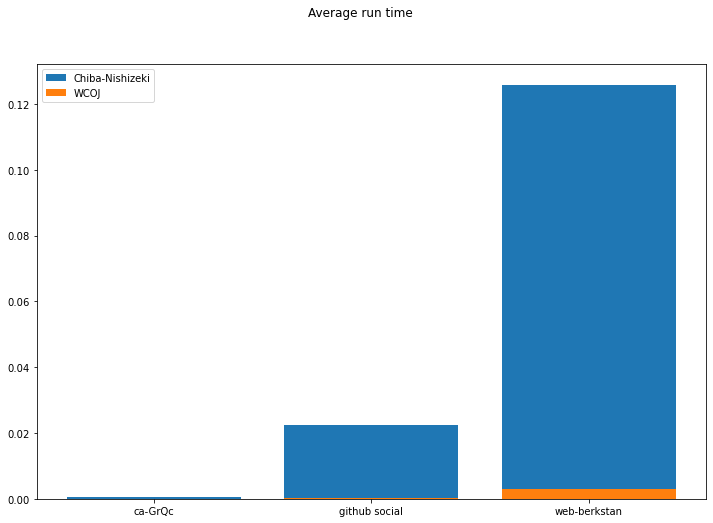

In [133]:
names = ['ca-GrQc', 'github social', 'web-berkstan']
#values_ = [1, 10, 100]

plt.figure(figsize=(12, 8))

plt.bar(names, cn_mean,label='Chiba-Nishizeki')
plt.bar(names,lpfj_mean,label='WCOJ')

plt.suptitle('Average run time')
plt.legend()
plt.show()